# Autoregressive logistic regression

Replicate example on _Changes in evapotranspiration rates_ presented in: 

- B. Kedem and K. Fokianos, Regression models for time series analysis, 2002, p. 39
- A. Agresti, Categorical data analysis, 3rd ed., 2014, p. 474  

In [1]:
import pandas as pd

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

3.5


In [2]:
SEED = 20180727

In [3]:
obs = [int(i) for i in str(111111110001111100000001111000100000111111110011000000011111100000000011111110000000)]
obs = np.asarray(obs)
print(obs)
print(obs.shape)

[1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 0 0 0 0 0 0 0]
(84,)


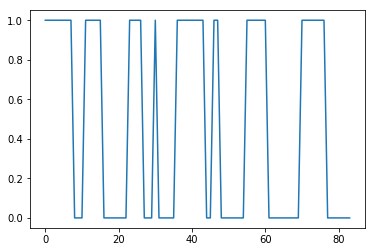

In [4]:
plt.plot(obs);

To build an autoregressive model, I use the observation at `t-1` as predictor for the observation at `t`

In [5]:
obs_t_minus_1 = obs[:-1].copy()
obs_t_minus_1

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

However, for the first observation I don't have the observation at the previous time step. Hence I will insert a missing observation (coded as `-1`)

In [6]:
obs_t_minus_1 = np.insert(obs_t_minus_1, 0, -1)
obs_t_minus_1.shape

(84,)

In [17]:
# There seems to be a problem when I have a single missing value. Here, I test with more than 1
obs_t_minus_1[:2] = -1

I will use the numpy `masked_array` to deal with the missing observation. In this way I can predict what the value for that observation was via the Bayesian inference

In [18]:
import numpy.ma as ma

In [19]:
obs_t_minus_1_ma = ma.masked_where(obs_t_minus_1==-1, obs_t_minus_1)
obs_t_minus_1_ma

masked_array(data=[--, --, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
                   0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
                   0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
                   0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                   1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
             mask=[ True,  True, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, Fal

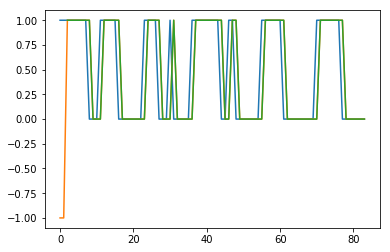

In [20]:
plt.plot(obs)
plt.plot(obs_t_minus_1)
plt.plot(obs_t_minus_1_ma) # the missing value is not plotted. That's good

In [27]:
with pm.Model() as model:
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    
    p_missing = pm.Beta('p_missing', alpha=2, beta=2)
    obs_t_minus_1_missing = pm.Bernoulli('obs_t_minus_1_missing', p=p_missing, observed=obs_t_minus_1_ma)
    
    p = pm.math.invlogit(alpha + pm.math.dot(beta, obs_t_minus_1_missing))
    
    print(obs_t_minus_1_ma.dtype)
    #p = np.zeros(obs.shape)
    #for t in np.arange(1, obs.shape[0]):
    #    p = pm.math.invlogit(alpha + beta*obs[t-1])
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=obs)
    
    trace = pm.sample(draws=1, tune=0, chains=4, cores=1, random_seed=SEED)

int32


Only 1 samples in chain.
Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [p_missing, beta, alpha]
>BinaryGibbsMetropolis: [obs_t_minus_1_missing_missing]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 34.50it/s]
d:\dev\pymc3\pymc3\sampling.py:476: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


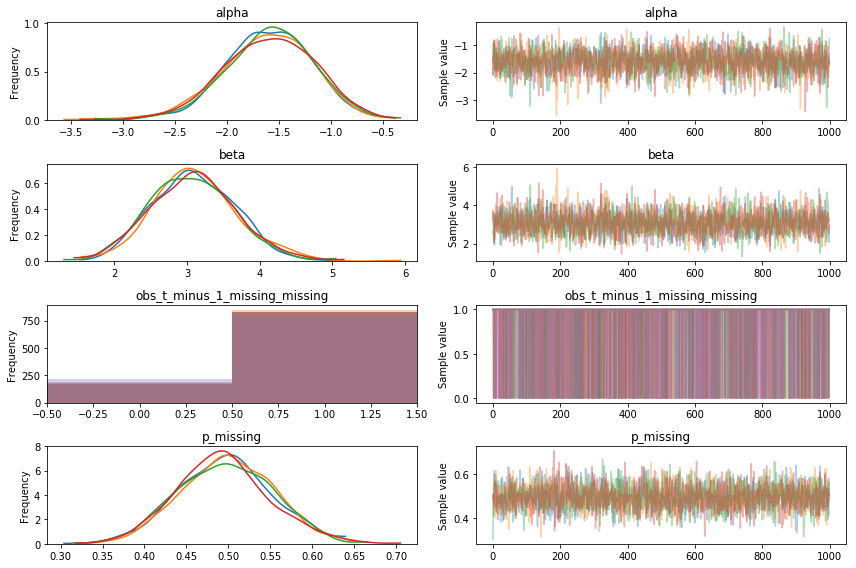

In [12]:
pm.traceplot(trace);

In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.606391,0.424728,0.009858,-2.439546,-0.804100,2286.397911,1.000286
beta,3.084005,0.578629,0.012134,1.925288,4.178239,2322.824367,1.000815
obs_t_minus_1_missing_missing__0,0.813750,0.389308,0.006850,0.000000,1.000000,3662.250240,1.000896
obs_t_minus_1_missing_missing__1,0.831500,0.374310,0.006006,0.000000,1.000000,4000.360212,1.000282
p_missing,0.495297,0.055103,0.001043,0.387232,0.599898,2711.557605,1.000536


In the Agresti's book the results are $(\alpha, \beta) = (-1.609, 2.996)$

In [14]:
with pm.Model() as model:
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100, shape=2)
    
    p_missing = pm.Beta('p_missing', alpha=2, beta=2)
    obs_t_minus_1_missing = pm.Bernoulli('obs_t_minus_1_missing', p=p_missing, observed=obs_t_minus_1_ma)
    
    #p = pm.math.invlogit(alpha + beta[0]*obs_t_minus_1_missing + beta[1]*np.arange(obs.shape[0]))
    p = pm.math.invlogit(alpha + beta[0]*obs_t_minus_1_missing + beta[1]*np.log1p(np.arange(obs.shape[0])))
    
    #tt.printing.Print('debug')(p)
    #p = np.zeros(obs.shape)
    #for t in np.arange(1, obs.shape[0]):
    #    p = pm.math.invlogit(alpha + beta*obs[t-1])
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=obs)
    
    trace = pm.sample(draws=1000, tune=1000, chains=4, cores=1, random_seed=SEED)

Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [p_missing, beta, alpha]
>BinaryGibbsMetropolis: [obs_t_minus_1_missing_missing]
100%|█████████████████████████████████████| 2000/2000 [00:09<00:00, 213.03it/s]


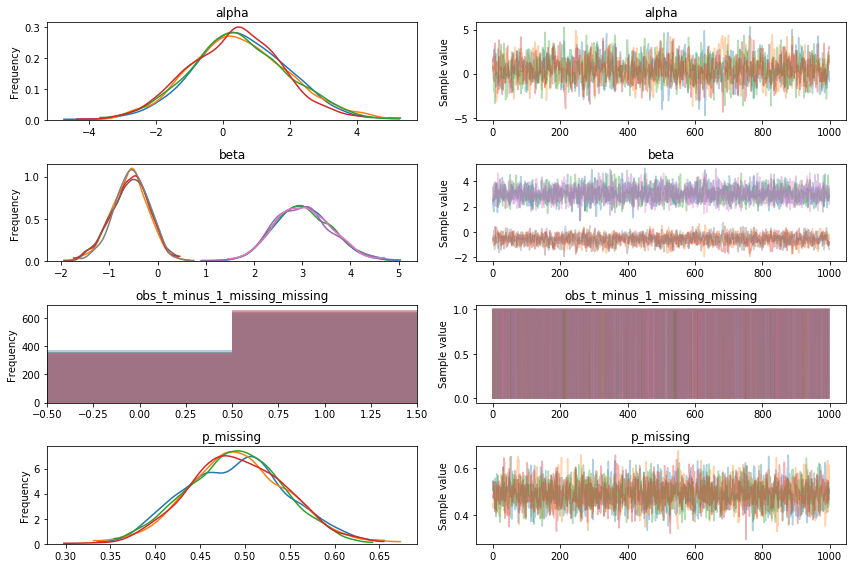

In [15]:
pm.traceplot(trace);

In [16]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.455310,1.422528,0.035448,-2.288021,3.313079,1480.413495,1.001364
beta__0,3.012376,0.591356,0.010521,1.912958,4.195908,2926.578137,0.999601
beta__1,-0.569143,0.383738,0.009632,-1.368138,0.134508,1489.853842,1.001538
obs_t_minus_1_missing_missing__0,0.639500,0.480146,0.006775,0.000000,1.000000,5273.860071,0.999943
obs_t_minus_1_missing_missing__1,0.652250,0.476256,0.006681,0.000000,1.000000,4938.743560,0.999616
p_missing,0.490688,0.054626,0.001015,0.384775,0.595315,2902.796779,0.999815


In [17]:
obs

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

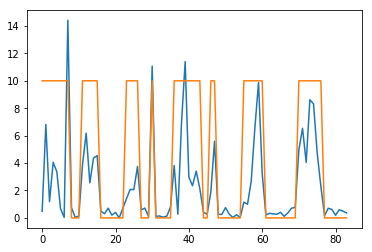

In [18]:
var = np.random.normal(loc=obs, scale=obs*5)
var += np.random.normal(0, 0.5, size=var.shape[0])
var = np.abs(var)
plt.plot(var)
plt.plot(obs*10)

In [19]:
with pm.Model() as model:
    
    #alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    
    #p_missing = pm.Beta('p_missing', alpha=2, beta=2)
    #obs_t_minus_1_missing = pm.Bernoulli('obs_t_minus_1_missing', p=p_missing, observed=obs_t_minus_1_ma)
    
    #p = pm.math.invlogit(alpha + beta[0]*obs[:-1] + beta[1]*var[1:])
    p = pm.math.invlogit(beta[0]*obs[:-1] + beta[1]*var[1:])
    
    #tt.printing.Print('debug')(p)
    #p = np.zeros(obs.shape)
    #for t in np.arange(1, obs.shape[0]):
    #    p = pm.math.invlogit(alpha + beta*obs[t-1])
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=obs[1:])
    
    trace = pm.sample(draws=5000, tune=1000, chains=4, cores=1, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta]
100%|████████████████████████████████████| 6000/6000 [00:05<00:00, 1050.99it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


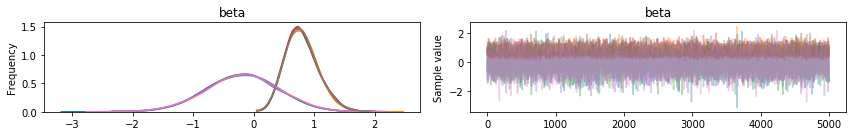

In [20]:
pm.traceplot(trace);

In [21]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-0.186887,0.591106,0.006872,-1.343501,0.956779,7351.215120,0.999933
beta__1,0.796758,0.271310,0.003081,0.292933,1.338269,7355.657849,0.999954


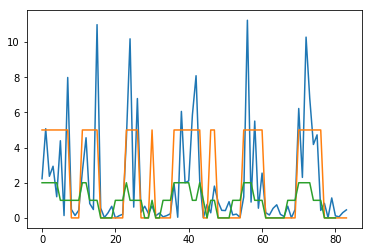

In [22]:
var = np.random.normal(loc=obs, scale=obs*5)
var += np.random.normal(0, 0.5, size=var.shape[0])
var = np.abs(var)
plt.plot(var)
plt.plot(obs*5)
plt.plot(obs[:-3] + obs[3:])

In [23]:
multinomial_obs = obs[:-3] + obs[3:]

In [24]:
# Number of categories
n_cat = len(set(multinomial_obs))
n_pred = 1

In [25]:
n_obs = multinomial_obs[:-1].shape[0]
n_obs

80

In [26]:
with pm.Model() as model:
    
    # priors for categories 1-2, excluding reference category 0 which is set to zero below.   
    alpha_ = pm.Normal('alpha_', mu=0, sd=50, shape=n_cat-1)
    beta_ = pm.Normal('beta_', mu=0, sd=50, shape=(n_pred, n_cat-1))
    
    # add prior values zero for reference category 0.
    alpha = pm.Deterministic('alpha', tt.concatenate([[0], alpha_]))
    beta = pm.Deterministic('beta', tt.concatenate([tt.zeros((n_pred, 1)), beta_], axis=1))

    p = tt.nnet.softmax(alpha + tt.dot(np.atleast_2d(multinomial_obs[:-1]).T, beta))
    
    likelihood = pm.Categorical('likelihood', p=p, observed=multinomial_obs[1:])
    
    trace = pm.sample(draws=3000, tune=1000, chains=2, cores=1, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_, alpha_]
100%|█████████████████████████████████████| 3500/3500 [00:12<00:00, 277.82it/s]


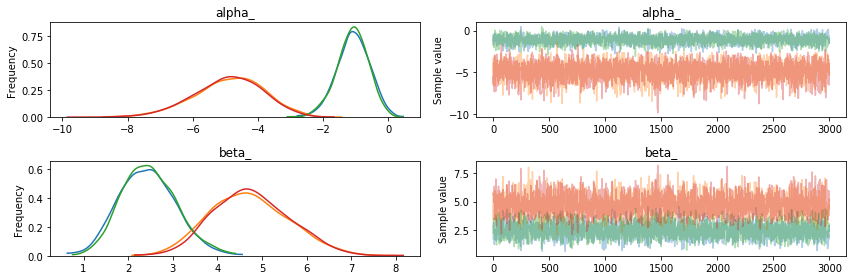

In [27]:
pm.traceplot(trace, varnames=['alpha_', 'beta_']);

In [28]:
pm.summary(trace, varnames=['alpha_', 'beta_'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha___0,-1.091249,0.487733,0.010802,-2.078896,-0.178280,2228.949500,1.000589
alpha___1,-4.901070,1.052986,0.020405,-7.013576,-2.937536,2290.827530,1.000399
beta___0_0,2.454146,0.620812,0.013181,1.246208,3.664064,2153.384705,1.001292
beta___0_1,4.743893,0.867090,0.017870,3.072877,6.411770,2016.527744,1.001041


Try softmax regression from DBDA2

In [38]:
df = pd.read_csv(r'..\datasets\SoftmaxRegData1.csv', dtype={'Y':'category'})
df.head()

,X1,X2,Y
0,-0.087147,-1.081342,2
1,-0.722566,-1.583863,1
2,0.179190,0.971790,3
3,-1.159752,0.502624,3
4,-0.727118,1.375704,3


In [74]:
Y, X = patsy.dmatrices('C(Y)~0+X1+X2', data=df)

In [75]:
Y

DesignMatrix with shape (475, 4)
  C(Y)[1]  C(Y)[2]  C(Y)[3]  C(Y)[4]
        0        1        0        0
        1        0        0        0
        0        0        1        0
        0        0        1        0
        0        0        1        0
        0        0        1        0
        1        0        0        0
        0        0        0        1
        0        1        0        0
        0        1        0        0
        0        0        1        0
        0        1        0        0
        0        0        0        1
        0        0        0        1
        0        0        0        1
        1        0        0        0
        0        1        0        0
        0        0        1        0
        0        0        1        0
        0        0        1        0
        0        0        1        0
        0        1        0        0
        1        0        0        0
        1        0        0        0
        0        0        1        0
     

In [76]:
X

DesignMatrix with shape (475, 2)
        X1        X2
  -0.08715  -1.08134
  -0.72257  -1.58386
   0.17919   0.97179
  -1.15975   0.50262
  -0.72712   1.37570
   0.53342   1.77465
  -0.18933  -0.53728
   0.48639   1.22362
   0.36356  -1.29798
   0.07069  -0.23240
  -1.58143   1.55258
   0.04855  -1.52247
   0.87477  -1.16198
   0.57757   0.69432
   0.14518   0.55809
  -0.47190  -1.27172
  -0.30880  -1.37919
  -0.28297   0.17724
  -0.04109   0.09105
   0.08522   0.89783
  -0.78485   0.85785
   0.89138  -0.79271
  -0.62737  -1.04602
  -1.33409  -1.07807
  -1.28905   1.60927
  -0.29945  -1.02952
  -0.84541   1.03352
   0.58230  -0.51385
   1.47912   1.10083
  -1.53038   0.37932
  [445 rows omitted]
  Terms:
    'X1' (column 0)
    'X2' (column 1)
  (to view full data, use np.asarray(this_obj))

In [51]:
# Number of categories
n_cat = df.Y.cat.categories.size
# Number of predictors
n_pred = X.shape[1]
n_cat, n_pred

(4, 3)

In [61]:
with pm.Model() as model:
    
    ## `p`--quantity that I want to model--needs to have size (n_obs, n_cat). 
    ## Because `X` has size (n_obs, n_pred), then `beta` needs to have size (n_pred, n_cat)
    
    # priors for categories 1-2, excluding reference category 0 which is set to zero below (see DBDA2 p. 651 for explanation).   
    beta_ = pm.Normal('beta_', mu=0, sd=50, shape=(n_pred, n_cat-1))
    # add prior values zero for reference category 0. (add a column)  
    beta = pm.Deterministic('beta', tt.concatenate([tt.zeros((n_pred, 1)), beta_], axis=1))
    
    # The softmax function will squash the values in the range 0-1
    p = tt.nnet.softmax(tt.dot(np.asarray(X), beta))
     
    likelihood = pm.Categorical('likelihood', p=p, observed=df.Y.cat.codes.values)
    
    trace = pm.sample(draws=3000, tune=1000, chains=2, cores=1, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_]
100%|█████████████████████████████████████| 4000/4000 [00:33<00:00, 120.37it/s]


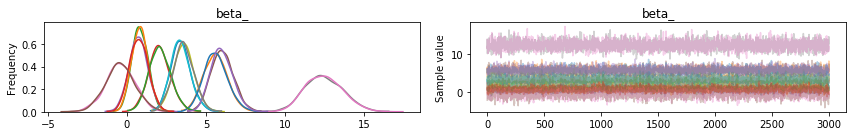

In [62]:
pm.traceplot(trace, varnames=['beta_']);